# Image augmentation

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

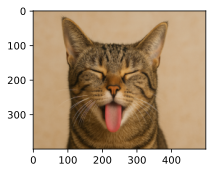

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../images/cat1.png')
d2l.plt.imshow(img)

This function runs the image augmentation method augmultiple times on the input image imgand shows all the results.

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### Cropping and flipping

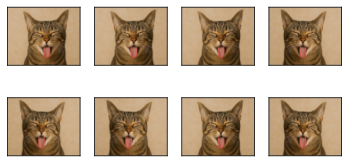

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

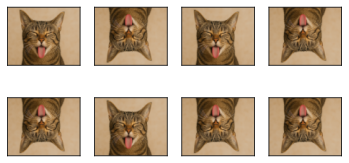

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

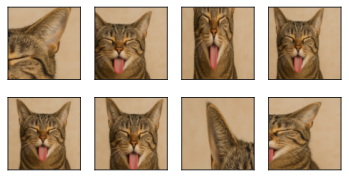

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### Changing Colors

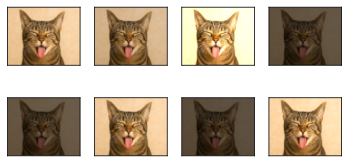

In [10]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.7, contrast=0, saturation=0, hue=0))

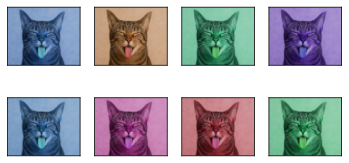

In [11]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

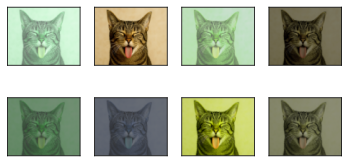

In [12]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### Combining Multiple Image Augmentation Methods

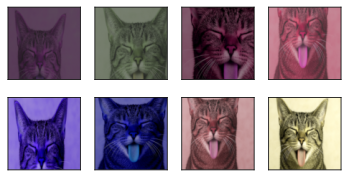

In [13]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

# Transfer Learning

We will fine-tune a ResNet model on a small dataset, which was pretrained on the ImageNet dataset. 

This small dataset consists of thousands of images with and without hot dogs. We will use the fine-tuned model to recognize hot dogs from images.

In [14]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [15]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

The first 8 positive examples and the last 8 negative images are shown below. As you can
see, the images vary in size and aspect ratio.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

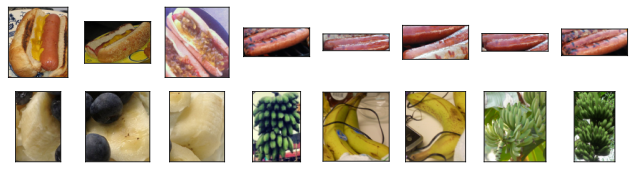

In [16]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

During training, we first crop a random area of random size and random aspect ratio from
the image, and then scale this area to a 224×224 input image. 

During testing, we scale both
the height and width of an image to 256 pixels, and then crop a central 224 × 224 area as
input. 

In [17]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], # means for R,G,B channel
                                             [0.229, 0.224, 0.225]) # stds for  R,G,B channel

train_augs = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor(),
                                            normalize])
test_augs = torchvision.transforms.Compose([torchvision.transforms.Resize([256, 256]),
                                            torchvision.transforms.CenterCrop(224),
                                            torchvision.transforms.ToTensor(),
                                            normalize])

We use ResNet-18, which was pretrained on the ImageNet dataset, as the source model.

The pretrained source model instance contains a number of feature layers and an output
layer `fc`. The main purpose of this division is to facilitate the fine-tuning of model parameters of all layers but the output layer.

In [18]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/beehuynh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


The member variable `fc` of source model is given below: As a fully connected layer, it transforms ResNet’s final global average pooling outputs (512 features) into
1000 class outputs of the ImageNet dataset.

In [19]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

We then construct a new neural network as
the target model. It is defined in the same way as the pretrained source model except that
its number of outputs in the final layer is set to the number of classes in the target dataset
(rather than 1000).

In the code below, the model parameters before the output layer of the target model instance `finetune_net` are initialized to model parameters of the corresponding layers from
the source model. We can only use a small learning rate to fine-tune such pretrained parameters.

In contrast, model parameters in the output layer are randomly initialized and generally require a larger learning rate to be learned from scratch. Letting the
base learning rate be 𝜂, a learning rate of 10𝜂 will be used to iterate the model parameters
in the output layer.

In [20]:
finetune_net = torchvision.models.resnet18(pretrained=True)

finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) # we want 2 output classes (hotdog vs non-hotdog)

nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0887,  0.0501,  0.0410,  ...,  0.0108,  0.0841, -0.0920],
        [-0.0664, -0.0146,  0.0447,  ...,  0.0458,  0.0086, -0.0539]],
       requires_grad=True)

In [21]:
# let's borrow some functions from the Builders Guide notebook

def gpu(i=0):  #@save
    """Get a GPU device."""
    if torch.backends.mps.is_available():
        return torch.device("mps")
    
    elif torch.cuda.is_available():
        return torch.device(f'cuda:{i}')
    
    else:
        return torch.device("cpu")
    
def num_gpus():  #@save
    if torch.backends.mps.is_available():
        return 1  # Only 1 MPS GPU is available
    elif torch.cuda.is_available():
        return torch.cuda.device_count()
    
def try_all_gpus():  #@save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]


In [22]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
                                            batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
                                            batch_size=batch_size)
    devices = try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")

    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight","fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
        
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

#### ATT: this takes hours!

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

For comparison, we define an identical model, but initialize all of its model parameters to
random values. 

Since the entire model needs to be trained from scratch, we can use a larger
learning rate.

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)